In [1]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl
from tensorflow.keras.callbacks import EarlyStopping



# 데이터셋 경로와 클래스 이름 설정
dataset_dir = r"C:\Users\User\분리수거" 
classes = ["병", "비닐", "종이", "캔", "플라스틱"]
num_classes = len(classes)

# 이미지 크기 및 채널 정의
img_height, img_width, channels = 150, 150, 3



In [3]:
# 이미지와 레이블을 담을 리스트 초기화
X, Y = [], []
for label_index, class_name in enumerate(classes):
    class_dir = os.path.join(dataset_dir, class_name)
    # 해당 클래스 디렉토리가 존재하는지 확인
    if not os.path.exists(class_dir):
        print(f"경고: 디렉토리 '{class_dir}'를 찾을 수 없습니다. 이 클래스는 건너뜁니다.")
        continue
    for filename in os.listdir(class_dir):
        # 이미지 파일만 처리
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        img_path = os.path.join(class_dir, filename)
        try:
            img = load_img(img_path, target_size=(img_height, img_width))
            X.append(img_to_array(img))
            Y.append(label_index)
        except Exception as e:
            print(f"오류: 이미지 '{img_path}' 로드 중 문제 발생: {e}")
            continue



In [5]:
X = np.array(X, dtype=np.float32)
Y = np.array(Y)
Y_one_hot = to_categorical(Y, num_classes=num_classes)
print(f"전체 이미지 개수: {X.shape[0]}")

전체 이미지 개수: 150


In [7]:
# ImageDataGenerator 설정 (데이터 증강을 통해 모델 성능 향상)
train_datagen = ImageDataGenerator(
    rescale=1.0/255, # 이미지 픽셀 값을 0-1 범위로 정규화
    rotation_range=20, # 20도 내에서 랜덤 회전
    width_shift_range=0.1, # 10% 내에서 가로 이동
    height_shift_range=0.1, # 10% 내에서 세로 이동
    zoom_range=0.1, # 10% 내에서 랜덤 줌
    horizontal_flip=True, # 가로 뒤집기
    vertical_flip=True, # 세로 뒤집기
    brightness_range=[0.5, 1.5], # 밝기 조절
    fill_mode='nearest' # 빈 공간을 채우는 방식
)
val_datagen = ImageDataGenerator(rescale=1.0/255) # 검증 데이터는 정규화만 수행


In [9]:
# 모델 생성 함수 (InceptionResNetV2를 기반으로 전이 학습 모델 생성)
def create_model():
    # InceptionResNetV2 모델을 불러오고, 최상위 분류 레이어는 포함하지 않음
    base = InceptionResNetV2(include_top=False, weights='imagenet',
                             input_shape=(img_height, img_width, channels))
    base.trainable = False # 기본 모델의 가중치를 동결 (전이 학습의 핵심)
    x = base.output
    x = GlobalAveragePooling2D()(x) # 특징 맵을 단일 벡터로 평탄화
    preds = Dense(num_classes, activation='softmax')(x) # 최종 분류 레이어 (클래스 수만큼 출력)
    model = Model(inputs=base.input, outputs=preds)
    model.compile(optimizer=Adam(), # Adam 옵티마이저 사용
                  loss='categorical_crossentropy', # 다중 클래스 분류에 적합한 손실 함수
                  metrics=['accuracy']) # 정확도 측정
    return model


    

In [11]:
# 1) 조기 종료 콜백 정의 (K-Fold 루프 전에)
early_stop = EarlyStopping(
    monitor='val_loss',       # 또는 'val_accuracy'
    patience=2,               # 2 에포크 연속 개선 없으면 멈춤
    restore_best_weights=True # 최적 가중치 복원
)


In [13]:
# Stratified K-Fold 교차 검증 (데이터 불균형을 고려하여 폴드 분할)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5개의 폴드로 분할, 셔플, 시드 고정
fold = 1
fold_accuracies = []
history = None # 마지막 폴드의 history 객체를 저장하기 위함

for train_idx, val_idx in skf.split(X, Y):
    print(f"\n[폴드 {fold} / 5]")
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = Y_one_hot[train_idx], Y_one_hot[val_idx]

    model = create_model() # 각 폴드마다 새로운 모델 생성
    train_gen = train_datagen.flow(X_train, y_train, batch_size=16) # 훈련 데이터 제너레이터
    history = model.fit( # 모델 훈련
        train_gen,
        epochs=10, # 훈련 에포크 수
        validation_data=(X_val/255.0, y_val), # 검증 데이터 (정규화 필요)
        callbacks=[early_stop],
        verbose=1 # 훈련 과정 출력
    )
  
    val_acc = history.history['val_accuracy'][-1] # 마지막 에포크의 검증 정확도
    fold_accuracies.append(val_acc)
    print(f"폴드 {fold} 종료 - 검증 정확도: {val_acc:.4f}")

    # 분류 리포트 (각 클래스별 성능 확인)
    y_val_idx = np.argmax(y_val, axis=1) # 원-핫 인코딩된 레이블을 인덱스로 변환
    y_pred_probs = model.predict(X_val/255.0) # 검증 데이터에 대한 예측 확률
    y_pred = np.argmax(y_pred_probs, axis=1) # 예측 확률을 클래스 인덱스로 변환
    print(f"[폴드 {fold} 분류 보고서]")
    print(classification_report(y_val_idx, y_pred, target_names=classes)) # 분류 보고서 출력

    fold += 1



[폴드 1 / 5]
Epoch 1/10
8/8 [==============================] - 13s 472ms/step - loss: 1.6912 - accuracy: 0.3583 - val_loss: 0.9148 - val_accuracy: 0.7000
Epoch 2/10
8/8 [==============================] - 1s 74ms/step - loss: 0.8100 - accuracy: 0.7083 - val_loss: 0.4611 - val_accuracy: 0.8333
Epoch 3/10
8/8 [==============================] - 1s 72ms/step - loss: 0.4631 - accuracy: 0.8167 - val_loss: 0.2474 - val_accuracy: 0.9333
Epoch 4/10
8/8 [==============================] - 1s 74ms/step - loss: 0.3886 - accuracy: 0.8833 - val_loss: 0.1751 - val_accuracy: 0.9667
Epoch 5/10
8/8 [==============================] - 0s 47ms/step - loss: 0.3229 - accuracy: 0.8750 - val_loss: 0.2186 - val_accuracy: 0.9333
Epoch 6/10
8/8 [==============================] - 1s 70ms/step - loss: 0.2614 - accuracy: 0.9167 - val_loss: 0.1164 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 1s 72ms/step - loss: 0.3000 - accuracy: 0.9000 - val_loss: 0.1025 - val_accuracy: 1.0000
Epoch 8/10
8/


5-Fold 평균 검증 정확도: 0.9200


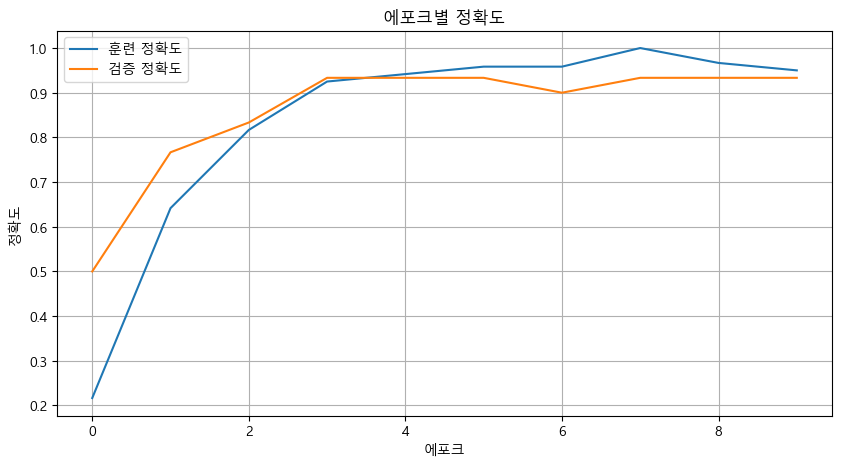

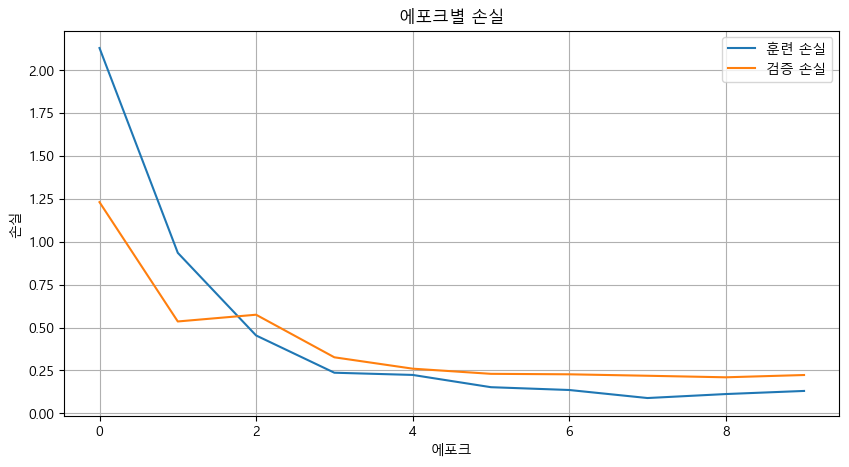

In [14]:
# 교차 검증 평균 정확도
mean_acc = np.mean(fold_accuracies)
print(f"\n5-Fold 평균 검증 정확도: {mean_acc:.4f}")
# 한글 폰트 설정 (그래프에 한글이 올바르게 표시되도록 설정합니다)
plt.rcParams['font.family'] = 'Malgun Gothic'
mpl.rcParams['axes.unicode_minus'] = False

# --- 여기서부터는 훈련 이력(정확도 및 손실)을 마지막 폴드의 결과를 사용하여 시각화합니다 ---
if history: # history 객체가 존재하는 경우에만 그래프를 그립니다.
    # 정확도 그래프
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='훈련 정확도')
    plt.plot(history.history['val_accuracy'], label='검증 정확도')
    plt.title('에포크별 정확도')
    plt.xlabel('에포크')
    plt.ylabel('정확도')
    plt.legend()
    plt.grid(True)
    plt.show() # 정확도 그래프 표시

    # 손실 그래프
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='훈련 손실')
    plt.plot(history.history['val_loss'], label='검증 손실')
    plt.title('에포크별 손실')
    plt.xlabel('에포크')
    plt.ylabel('손실')
    plt.legend()
    plt.grid(True)
    plt.show() # 손실 그래프 표시
else:
    print("경고: 훈련 이력(history)이 없어 정확도 및 손실 그래프를 그릴 수 없습니다.")


1/1 [==============================] - 0s 164ms/step


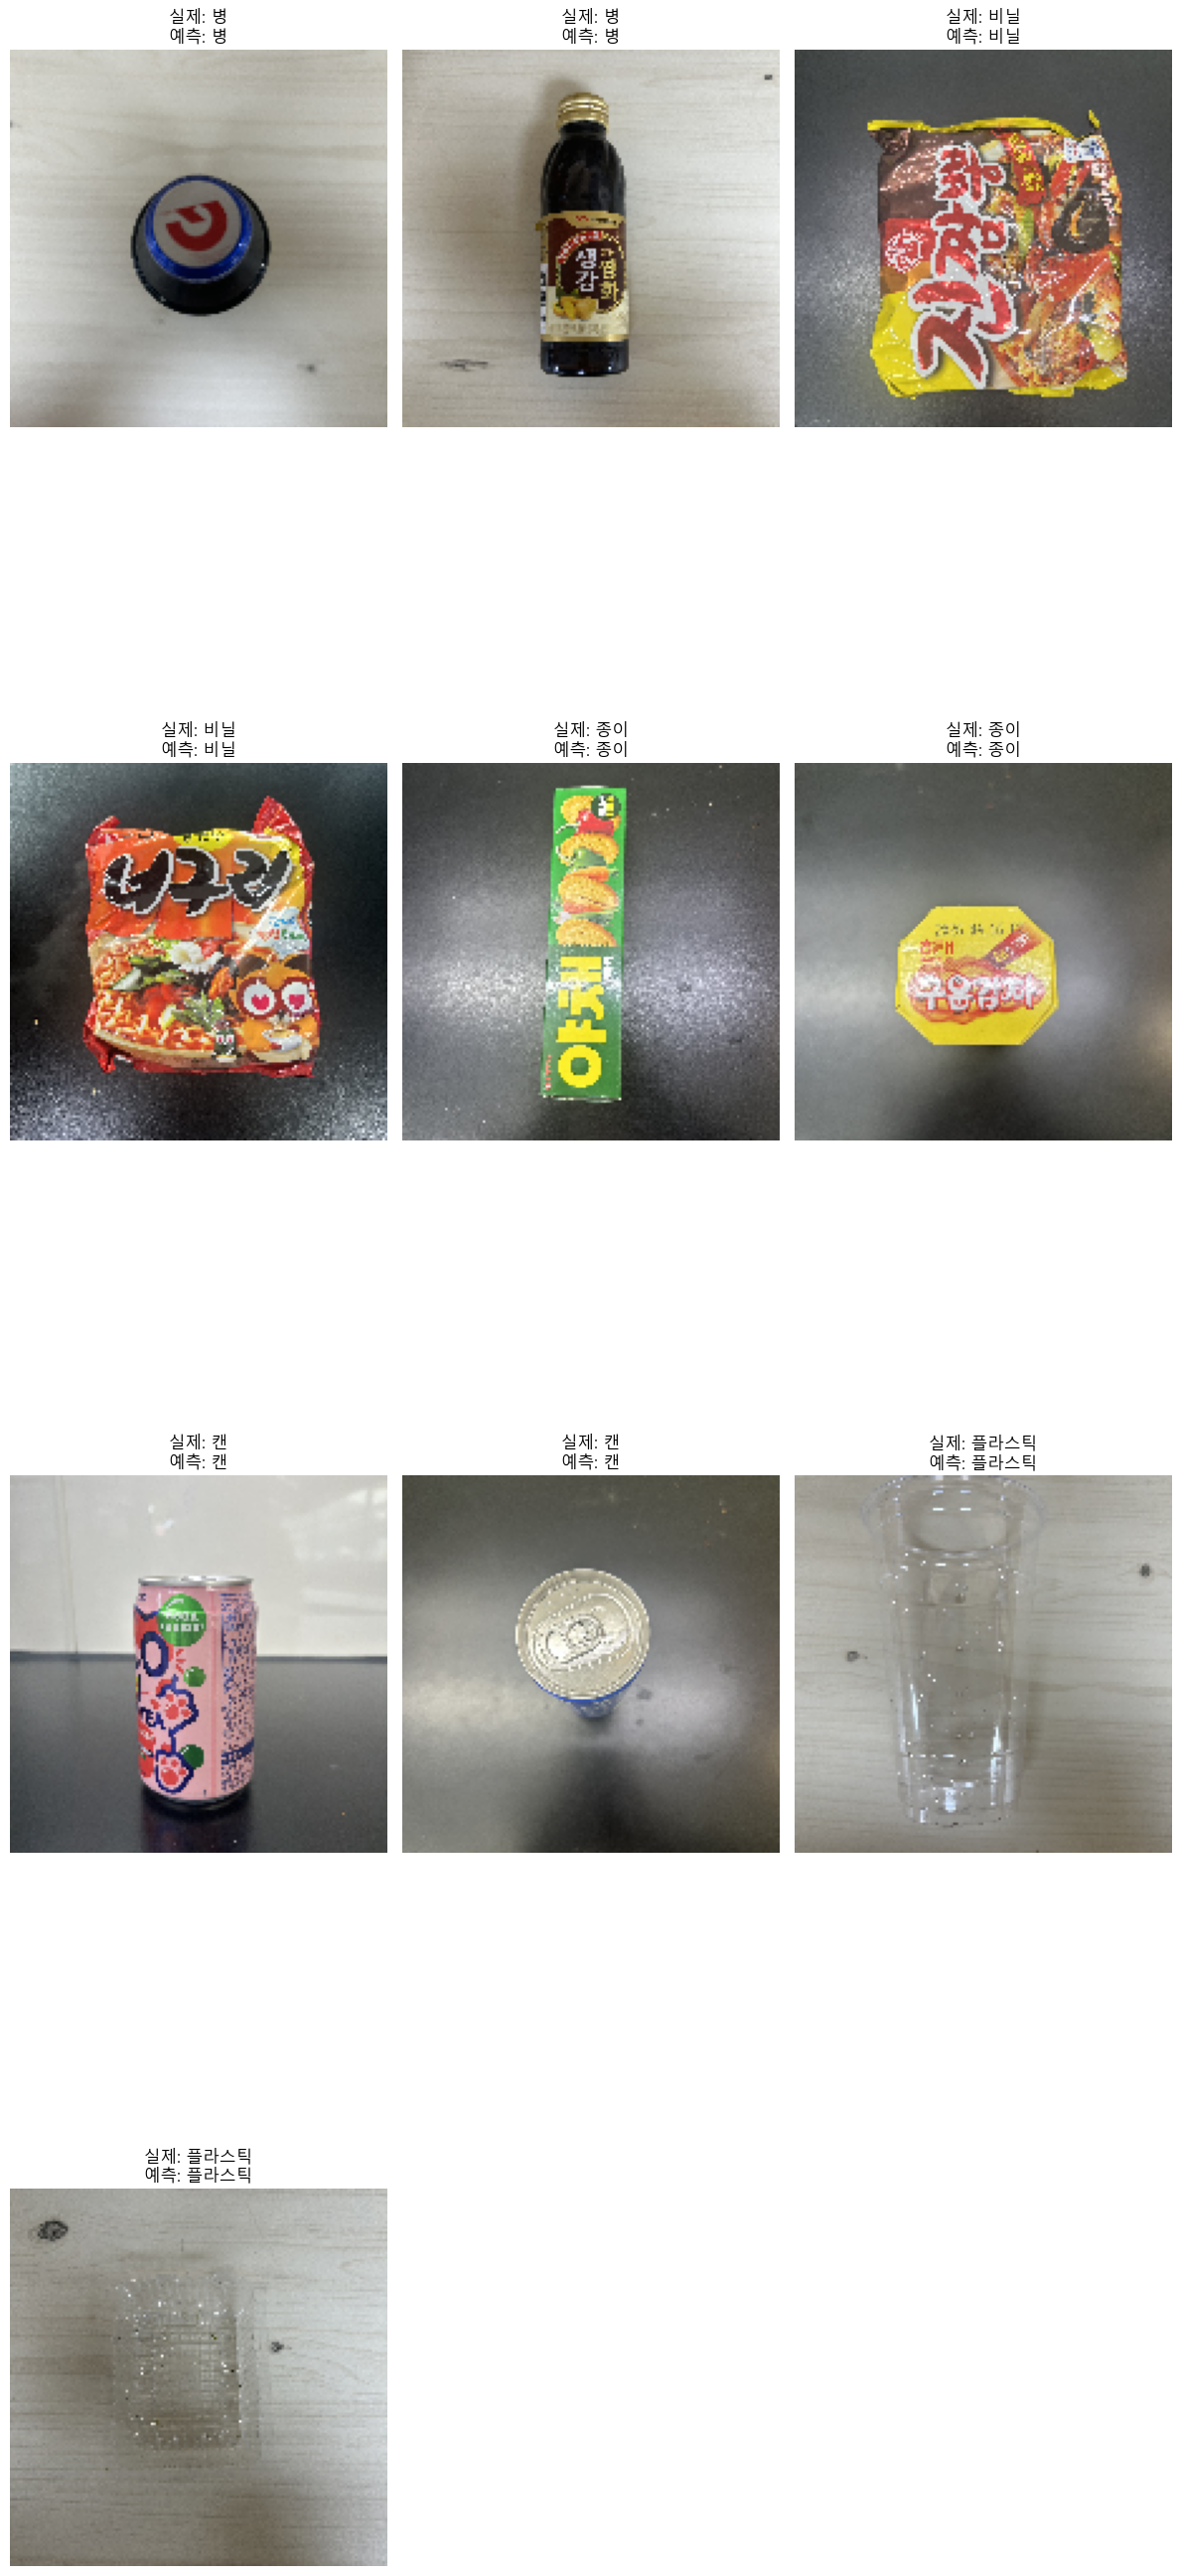

In [15]:
# --- 여기서부터는 마지막 훈련된 모델을 사용하여 예측 및 시각화를 수행 ---

# 테스트용 디렉토리: 별도의 'test' 폴더가 없다면 dataset_dir을 그대로 사용
test_dir = dataset_dir

# 클래스별로 2장씩 이미지 불러오기 (예측 시각화를 위한 샘플 이미지)
images, labels, paths = [], [], []
for class_name in classes:
    class_test_dir = os.path.join(test_dir, class_name)
    if not os.path.exists(class_test_dir):
        print(f"경고: 테스트 디렉토리 '{class_test_dir}'를 찾을 수 없습니다. 이 클래스 테스트는 건너뜁니다.")
        continue
    # 각 클래스에서 최대 2개의 이미지 파일을 가져옴
    image_files = [
        f for f in os.listdir(class_test_dir)
        if f.lower().endswith(('.png','.jpg','.jpeg'))
    ][:2] # 각 클래스에서 최대 2개의 이미지 파일만 선택
    for filename in image_files:
        img_path = os.path.join(class_test_dir, filename)
        try:
            img = load_img(img_path, target_size=(150,150))
            images.append(img_to_array(img)/255.0) # 이미지 로드 및 정규화
            labels.append(class_name) # 실제 레이블 저장
            paths.append(img_path) # 이미지 경로 저장
        except Exception as e:
            print(f"오류: 테스트 이미지 '{img_path}' 로드 중 문제 발생: {e}")
            continue

if len(images) > 0:
    images_array = np.array(images) # 이미지 리스트를 넘파이 배열로 변환
    pred_probs = model.predict(images_array) # 마지막 훈련된 모델로 예측 확률 계산
    pred_idx = np.argmax(pred_probs, axis=1) # 확률을 클래스 인덱스로 변환
    pred_labels = [classes[i] for i in pred_idx] # 인덱스를 클래스 이름으로 변환

    n = len(images)
    plt.figure(figsize=(12, n*3)) # 그래프 크기 설정
    for i in range(n):
        plt.subplot((n+2)//3, 3, i+1) # 서브플롯 설정
        plt.imshow(images_array[i]) # 이미지 표시
        plt.axis('off') # 축 제거
        plt.title(f"실제: {labels[i]}\n예측: {pred_labels[i]}") # 제목에 실제/예측 레이블 표시
    plt.tight_layout() # 서브플롯 간 간격 자동 조절
    plt.show() # 이미지 예측 결과 그래프 표시
else:
    print("경고: 테스트할 이미지를 찾을 수 없습니다. 이미지 예측 시각화를 건너뜁니다.")